In [ ]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [4]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [8]:
cd ..


/home/u/wartytw


In [9]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"

shape = np.load("Resection_stage1/shape.npz.npy")
resec = np.load("Resection_stage1/resec.npy")
y = np.load("Resection_stage1/resec_y.npy")


In [22]:
#Test
#New
def extract_cube(r, img):#cube 210, 220, 90 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((210, 220, 90))
    #print(img.shape, r)
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp


def masking(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] == 0 or label[i, j] == 1:
                img[i, j] = 0
    return img



In [11]:
shape_tumor

NameError: name 'shape_tumor' is not defined

In [19]:
#New
def extract_cube(r, img):#cube 360, 300, 110 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((360, 300, 110))
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp

In [20]:
image_t = load_image(os.path.join(image_path, "IM_"+resec[0]+".nii.gz"))
label_t = load_image(os.path.join(label_path, "LB_"+resec[0]+".nii.gz"))

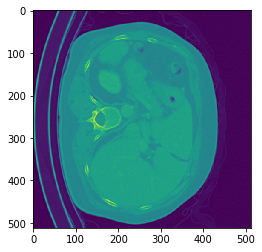

In [23]:
plt.imshow(image_t[..., 70])
plt.show()

In [ ]:
plt.imshow(label_t[..., 70])
plt.show()


In [25]:
print(image_t[..., 70].shape)
print(label_t[..., 70].shape)

(512, 512)
(512, 512)


In [7]:
import cv2
mask_inv = cv2.bitwise_not(label_t[..., 70])

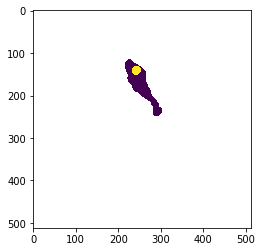

In [8]:
plt.imshow(mask_inv)
plt.show()

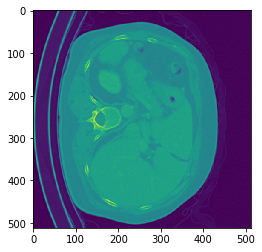

In [9]:
plt.imshow(image_t[..., 70])
plt.show()

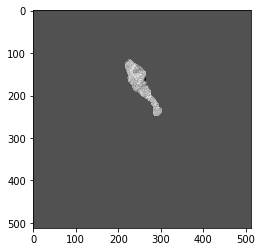

In [24]:
for i in range(512):
    for j in range(512):
        if label_t[i, j, 70] == 0:
            image_t[i, j, 70] = 0
plt.imshow(image_t[..., 70], cmap = 'gray')
plt.show()

In [25]:
from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

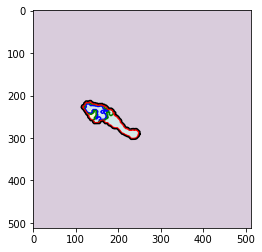

In [82]:
img = image_t[..., 70]
detector = CENSURE()
detector.detect(img)
#summarize
from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

def set_to_100(vec):
    vs = vec.shape[0]
    if (vs < 100):
        r = 100 - vs
        vec = np.concatenate(( vec.reshape(-1, vec.shape[1]), np.zeros((r, vec.shape[1]))), axis = 0)
    
    vec = vec[tuple(list(np.round(np.linspace(1, vec.shape[0] - 1, 100)).astype(int) )), :]    
    return vec
#closing

def isZero(vec):
    if (vec == []):
        return True
    return False

def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]


keypoint = detector.keypoints
scale = detector.scales
num = 70
erosion = cont(ndi.morphology.binary_erosion(img > num, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img > num, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img > num, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img > num, structure=struct).astype(img.dtype))

plt.imshow(label_t[..., 70].T, alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')

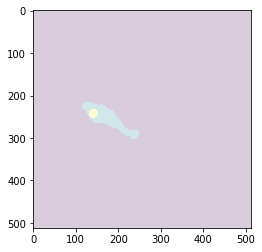

In [83]:
plt.imshow(label_t[..., 70].T, alpha=.2)

In [86]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


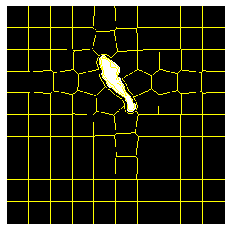

In [87]:
image = image_t[..., 70]
segments = slic(img_as_float(image), n_segments = 100, sigma = 5)
 
# show the output of SLIC
fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")
plt.show()

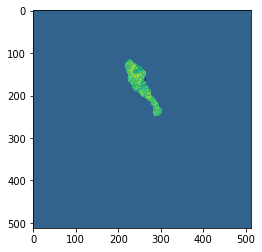

In [84]:
plt.imshow(image_t[..., 70])
plt.show()

(512, 512, 3)
(512, 512)


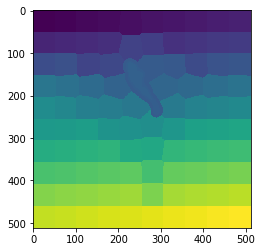

NameError: name 'label0' is not defined

In [88]:
print(mark_boundaries(image, segments).shape)
print(segments.shape)

plt.imshow(segments)
plt.show()

masked = np.ma.masked_where(label0[:, :, _slice] == 0, label0[:, :, _slice])
plt.imshow(segments[ :, :])
plt.imshow(masked, cmap='gray', alpha=0.5)
plt.title('Masked')
plt.show()

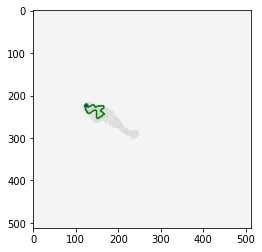

In [58]:
plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(o1[0][::,0], o1[0][::,1], c='b')
plt.plot(o2[0][::,0],o2[0][::,1], c='g')
plt.show()

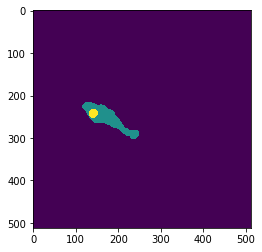

In [46]:
plt.imshow(label_t[..., 70].T)
plt.show()

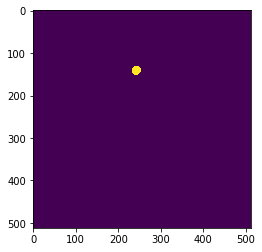

In [15]:
plt.imshow(label_t[:, :, 70])

In [14]:
for i in range(label_t.shape[0]):
    for j in range(label_t.shape[1]):
        if label_t[i, j, 70] != 2:
            label_t[i, j, 70] = 0
            


In [9]:
from scipy import ndimage
#ndimage.binary_dilation(a).astype(a.dtype)

In [16]:
tmp_label = ndimage.binary_dilation(label_t[:, :, 70]).astype(label_t[:, :, 70].dtype)

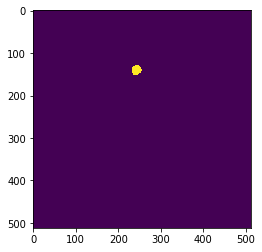

In [17]:
plt.imshow(tmp_label)

In [20]:
np.where(tmp_label != 0)[0].shape

(423,)

In [21]:
np.where(label_t[:, :, 70] != 0)[0].shape

(360,)

In [22]:
from keras import metrics
tmp_x = Input((210, 220, 90, 1))
x = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(tmp_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=8, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)



x = Conv3D(filters=4, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)






x = Flatten()(x)
x = Dense(units=500, kernel_initializer='normal', activation='elu')(x)
x = Dense(units=100, kernel_initializer='normal', activation='relu')(x)
x = Dense(units=1, kernel_initializer='normal', activation='sigmoid')(x)

model = Model(inputs=tmp_x, outputs=x)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

Using TensorFlow backend.


NameError: name 'Input' is not defined